### Escopo para cálculo de parâmetros da aba Maturação 

In [1]:
# Input de dados de pirólise (leitura de planilha .csv)
# Agrupamento de dados (cluster)
# Cálculo de COTa
# Cálculo de IHa = 100 x (S2/(COTa))
# Calculo de Tr sem vitrinita: (IHa - IH)/ IHa
# Cálculo de Ro a partir de Tmax: Ro calculada = (0,0180 x Tmax) - 7,16
# Classificação do querogênio
# Cálculo de Tr por Ro e tipo de querogênio
# Normalização dos valores de Tr na curva log (ln)
# Cálculo de TOC0, S20 e IH0
# Gráficos
# Comparação entre os resultados de Tr (Ro x IH)  

##### Dependências

In [2]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

##### Customização dos gráficos

In [3]:
# keys = plt.rcParams.keys()
# print(keys)
# 'font.sans-serif': "Verdana",

custom_style = {
    'figure.figsize': (8, 6),
    'font.family':'sans-serif',
    'axes.facecolor': 'lightgray',
    'figure.facecolor':'silver',
    'lines.linewidth': 2,
    'scatter.marker': 'o',
    'font.size': 9,
    'axes.grid': True
    }

##### Input de dados de pirólise (leitura de planilha .csv)

In [4]:
df = pd.read_csv("Poços_Marinho/1-ALS-2-AL.csv")
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43
...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78


##### Agrupamento por parâmetros de pirólise

/home/rodrigo/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


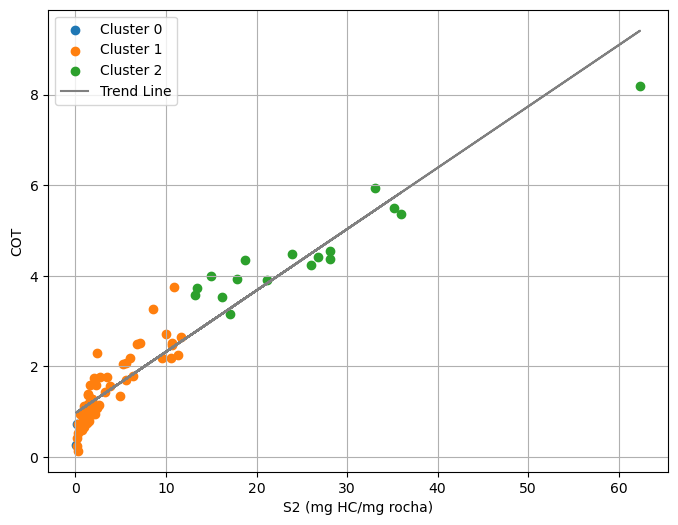

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1
...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0


In [5]:
# Number of clusters you want to create
num_clusters = 3  

# Extract the columns for clustering

X = df[["COT","S1","S2","S3","Tmax"]].fillna(0)

# Optional: Scale the data (if needed)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Apply k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)  # Use X_scaled if you scaled the data, otherwise use X

# Get cluster assignments and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Add cluster labels to the original data frame
df['Cluster'] = cluster_labels

# Scatter plot
plt.figure(figsize=(8, 6))

# Plot data points for each cluster
for cluster_id in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    plt.scatter(cluster_data["S2"], cluster_data["COT"], label=f'Cluster {cluster_id}')

# Extract data from DataFrame
df1=df.dropna(subset=["COT","S2"])
x_data = df1['S2'].values.reshape(-1, 1)
y_data = df1['COT'].values

# Fit linear regression model
model = LinearRegression()
model.fit(x_data, y_data)

# Get the slope (coefficient) and y-intercept of the trend line
slope = model.coef_[0]
intercept = model.intercept_


# Plot the trend line
plt.plot(x_data, model.predict(x_data), color='gray', label='Trend Line')

plt.xlabel("S2 (mg HC/mg rocha)")
plt.ylabel("COT")
plt.title('')
plt.legend()
plt.grid(True)
plt.style.use(custom_style)
plt.show()
df

##### Equação de regressão linear para cada cluster

In [6]:
models = {}

for cluster_id in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    x_values = cluster_data[["S2"]].fillna(value=0)
    y_values = cluster_data["COT"]
    model = LinearRegression()
    model.fit(x_values, y_values)
    models[cluster_id] = model

# Print the linear regression equations for each cluster
dic={}
for cluster_id, model in models.items():
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f"Cluster {cluster_id} - y = {slope:.2f} * x + {intercept:.2f}")
    #dic={cluster_id:intercept}
    dic[cluster_id]=intercept
    print(dic)

Cluster 0 - y = -0.85 * x + 0.71
{0: 0.7080097087378642}
Cluster 1 - y = 0.19 * x + 0.79
{0: 0.7080097087378642, 1: 0.7940621234463975}
Cluster 2 - y = 0.09 * x + 2.15
{0: 0.7080097087378642, 1: 0.7940621234463975, 2: 2.146608469927514}


In [7]:
dic[1]

0.7940621234463975

##### Cálculo de COT ativo utilizando regressão linear

In [8]:
COTativo=[]
for idx,row in df.iterrows():
    #print(row["Cluster"])
    Cluster=row["Cluster"]
    COT=row["COT"]
    intercept=dic[Cluster]
    COTa= COT- intercept
    COTativo.append(COTa)
df["COTa"]=COTativo
df
COT_cor=[]
for i in df["COTa"]:
    if i >= 0:
        COT_cor.append(i)
    else:
        COT_cor.append(0)
df["COTa"]=COT_cor
df


,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.705938
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.715938
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.385938
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.265938
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.495938
...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.011990


##### Cálculo de IH0ativo
* IHa = 100 x (S2/(COTa))

In [9]:
IHa = 100*(df["S2"]/df["COTa"])
IHa_cor=[]
for i in IHa:
    if i<0:
        IHa_cor.append(0)
    elif i>=0 or i<=999:
        IHa_cor.append(i)
    else:
        IHa_cor.append(999) # Eliminar valores
df["IH0a"]= IHa_cor
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IH0a
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.705938,401.538655
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.715938,415.516208
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.385938,436.527503
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.265938,417.082078
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.495938,354.883158
...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,999.000000
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000,inf
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000,inf
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.011990,1668.016194


##### Calculo da Taxa de Transformação sem Ro (IH)
* (IHa - IH)/ IHa

In [10]:
df["Taxa de Transformação (IH)"] = ((df["IH0a"]-df["IH"])/df["IH0a"])
TrIH=[]
for i in df["Taxa de Transformação (IH)"]:
    if i<0:
        TrIH.append(0)
    elif i>1:
        TrIH.append=1
    else:
        TrIH.append(i)
df["Taxa de Transformação (IH)"]=TrIH
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH)
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.705938,401.538655,0.317625
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.715938,415.516208,0.316368
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.385938,436.527503,0.364255
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.265938,417.082078,0.385469
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.495938,354.883158,0.615564
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,999.000000,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000,inf,NaN
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000,inf,NaN
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.011990,1668.016194,0.983345


##### Cálculo de Ro a partir de Tmax
* Ro calculada = (0,0180 x Tmax) - 7,16

In [11]:
df["Ro (calculada)"] = (0.0180*df["Tmax"])-7.16
Roc_cor=[]
for i in df["Ro (calculada)"]:
    if i<0:
        Roc_cor.append(0)
    else:
        Roc_cor.append(i)
df["Ro (calculada)"]=Roc_cor
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada)
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.705938,401.538655,0.317625,0.580
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.715938,415.516208,0.316368,0.562
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.385938,436.527503,0.364255,0.580
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.265938,417.082078,0.385469,0.580
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.495938,354.883158,0.615564,0.544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,999.000000,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000,inf,NaN,0.814
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000,inf,NaN,NaN
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.011990,1668.016194,0.983345,NaN


#### Classificação do querogênio
* Tipo I: {IH > 600} ___ {S1/S3 > 15}
* Tipo II: {IH > 300 and IH <= 600} ___ {S1/S3 > 10 and S1/S3 <15}
* Tipo II/III: {IH > 200 and IH <=300} ___ {S1/S3 > 5 and S1/S3 < 10]
* Tipo III: {IH > 50 and IH <= 200} ___ {S1/S3 > 1 and S1/S3 < 5}
* Tipo IV: {IH <= 50} ___ {S1/S3 > 1}

In [12]:

K = []
for i in df["IH"]:
    if i > 600:
        a="Tipo I"
    elif i > 300 and i <=600:
        a="Tipo II"
    elif i > 200 and i <= 300:
        a="Tipo II/III"
    elif i > 50 and i <= 200:
        a="Tipo III"
    elif i>0 and i<=50:
        a="Tipo IV"
    else:
        a=""
    K.append(a)
querogênio=pd.DataFrame(K)
df["Querogênio"]=querogênio
df


,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada),Querogênio
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.705938,401.538655,0.317625,0.580,Tipo II/III
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.715938,415.516208,0.316368,0.562,Tipo II/III
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.385938,436.527503,0.364255,0.580,Tipo II/III
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.265938,417.082078,0.385469,0.580,Tipo II/III
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.495938,354.883158,0.615564,0.544,Tipo III
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,999.000000,NaN,NaN,
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000,inf,NaN,0.814,Tipo IV
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000,inf,NaN,NaN,Tipo IV
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.011990,1668.016194,0.983345,NaN,Tipo IV


In [13]:
# End Member

T1 = []
T2 = []
T3 = []
T4 = []
for i in df["IH"]: 
    if i >= 600:
        end = ((i - 999)/(600 - 999))*100
        T1.append(100) 
        T2.append(0)
        T3.append(0)
        T4.append(0) 
    elif i >= 300 and i <=600:
        end = ((i - 600)/(300 - 600))*100
        T1.append(100-end) 
        T2.append(end)
        T3.append(0)
        T4.append(0) 
    elif i >= 50 and i < 300:
        end = ((i - 300)/(50 - 300))*100
        T1.append(0) 
        T2.append(100-end)
        T3.append(end)
        T4.append(0) 
    else:
        end = ((i - 50)/(0 - 50))*100
        T1.append(0) 
        T2.append(0)
        T3.append(100-end)
        T4.append(end) 
df["% Tipo I"]=T1
df["% Tipo II"]=T2
df["% Tipo III"]=T3
df["% Tipo IV"]=T4
df




,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada),Querogênio,% Tipo I,% Tipo II,% Tipo III,% Tipo IV
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,1.705938,401.538655,0.317625,0.580,Tipo II/III,0.0,89.600,10.400,0.00
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,1.715938,415.516208,0.316368,0.562,Tipo II/III,0.0,93.624,6.376,0.00
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,1.385938,436.527503,0.364255,0.580,Tipo II/III,0.0,91.008,8.992,0.00
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,1.265938,417.082078,0.385469,0.580,Tipo II/III,0.0,82.524,17.476,0.00
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,0.495938,354.883158,0.615564,0.544,Tipo III,0.0,34.572,65.428,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,999.000000,NaN,NaN,,0.0,0.000,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,0.000000,inf,NaN,0.814,Tipo IV,0.0,0.000,91.660,8.34
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,0.000000,inf,NaN,NaN,Tipo IV,0.0,0.000,76.920,23.08
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,0.011990,1668.016194,0.983345,NaN,Tipo IV,0.0,0.000,55.560,44.44


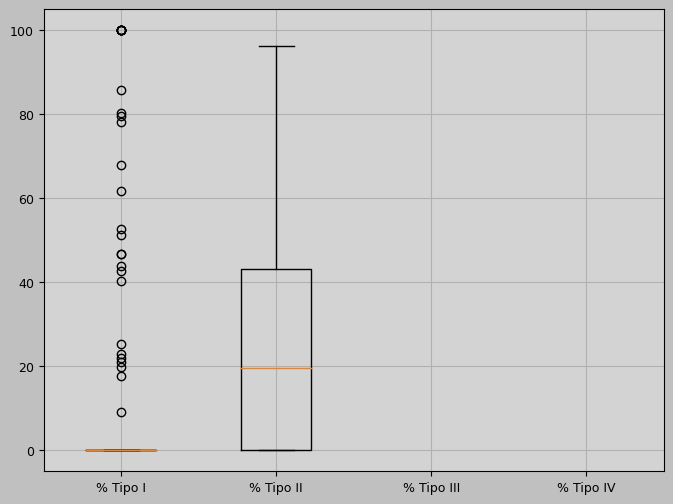

In [14]:
TI=df["% Tipo I"]
TII=df["% Tipo II"]
TIII=df["% Tipo III"]
TIV=df["% Tipo IV"]
data=[TI,TII,TIII,TIV]
plt.boxplot(data)
custom_labels_x = ['% Tipo I', '% Tipo II', '% Tipo III', '% Tipo IV']
plt.xticks(np.arange(1, len(custom_labels_x) + 1), custom_labels_x)
plt.style.use(custom_style)
plt.show()

#### Cálculo de Tr por Ro e tipo de querogênio
* Tipo_I = -34.430609 + (183.63837 * Ro) - (361.494 * Ro**2) + (309.9 * Ro**3) - (96.8 * Ro**4)
* Tipo_II = -822.70308 + (6217.2684 * Ro) - (19265.314 * Ro**2) + (31326.872 * Ro**3) - (28204.703 * Ro**4) + (13345.477 * Ro**5) - (2595.9299 * Ro**6)
* Tipo_III = 6.6516023 - (33.879196 * Ro) + (64.978399 * Ro**2) - (60.264818 * Ro**3) + (29.700408 * Ro**4) - (7.5019085 * Ro**5) + (0.7656397 * Ro**6)


In [15]:
Ro = df["Ro (calculada)"].mean()
print("Valor medio da Ro calculada:", Ro )
#for Ro in df["Ro (calculada)"]:
Eq_I = -34.430609 + (183.63837 * Ro) - (361.494 * Ro**2) + (309.9 * Ro**3) - (96.8 * Ro**4)
Eq_II = -822.70308 + (6217.2684 * Ro) - (19265.314 * Ro**2) + (31326.872 * Ro**3) - (28204.703 * Ro**4) + (13345.477 * Ro**5) - (2595.9299 * Ro**6)
Eq_III = 6.6516023 - (33.879196 * Ro) + (64.978399 * Ro**2) - (60.264818 * Ro**3) + (29.700408 * Ro**4) - (7.5019085 * Ro**5) + (0.7656397 * Ro**6)
    
if TI.mean()+TI.std() > TII.mean()+TII.std() and TI.mean()+TI.std() > TIII.mean()+TIII.std() and TI.mean()+TI.std() > TIV.mean()+TIV.std():
    TRo=Eq_I
    print("Querogênio Tipo I")
elif TII.mean()+TII.std() > TI.mean()+TI.std() and TII.mean()+TII.std() > TIII.mean()+TIII.std() and TII.mean()+TII.std() > TIV.mean()+TIV.std():
    TRo=Eq_II
    print("Querogênio Tipo II")
elif TIII.mean()+TIII.std() > TI.mean()+TI.std() and TIII.mean()+TIII.std() > TII.mean()+TII.std() and TIII.mean()+TIII.std() > TIV.mean()+TIV.std():
    TRo=Eq_III
    print("Querogênio Tipo III")
else:
    TRo=0
    print("Querogênio Tipo IV")
print("Taxa de TRansformação (Ro):", TRo)

if i > 1:
    TRo = 1
elif TRo < 0:
    TRo = 0
else:
    TRo = TRo
#df["Taxa de Transformação (Ro)"]=TRo
#df

Valor medio da Ro calculada: 0.6936129032258057
Querogênio Tipo III
Taxa de TRansformação (Ro): 0.05867102297416635


#### Normalização dos valores de Tr na curva log (ln)

In [16]:
L = 120 #float(input("Lâmina d'água: "))


MRo = TRo#df["Taxa de Transformação (Ro)"].mean()
MIH = df["Taxa de Transformação (IH)"].median()
MinIH = df["Taxa de Transformação (IH)"].min()
MedIH = df["Taxa de Transformação (IH)"].mean()

    # 4. Ajustar uma curva logaritmica com a profundidade da lamina dagua e a profundidade final e o tr na lamina dagua (zero) e o tr na profundidade final (mediana ou mínimo), utilizando scipy curve_fit

# Cálculo para valores de Ro calculada
x1 = [L, df["Profundidade"].max()]
y1 = [0, MRo]

log_fit = scipy.optimize.curve_fit(lambda t, a1, b1: a1 + b1 * np.log(t), x1, y1)
a1 = log_fit[0][0]
b1 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_Ro_Log'] = a1 + b1 * np.log(df["Profundidade"])

#================================================#

# Cálculo para valores de IH (mediana)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (mdn)'] = a2 + b2 * np.log(df["Profundidade"])
df

#================================================#

# Cálculo para valores de IH (mínimo)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MinIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (min)'] = a2 + b2 * np.log(df["Profundidade"])
df
#================================================#

# Cálculo para valores de IH (média)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MedIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (med)'] = a2 + b2 * np.log(df["Profundidade"])
df
    # Extra: aplicando novamente filtro para que tr seja 0 abaixo da lamina d'agua


/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,...,Ro (calculada),Querogênio,% Tipo I,% Tipo II,% Tipo III,% Tipo IV,Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med)
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,...,0.580,Tipo II/III,0.0,89.600,10.400,0.00,0.027711,0.283197,0.099739,0.280666
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,...,0.562,Tipo II/III,0.0,93.624,6.376,0.00,0.028248,0.288693,0.101675,0.286113
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,...,0.580,Tipo II/III,0.0,91.008,8.992,0.00,0.028770,0.294027,0.103553,0.291399
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,...,0.580,Tipo II/III,0.0,82.524,17.476,0.00,0.029277,0.299207,0.105377,0.296532
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,...,0.544,Tipo III,0.0,34.572,65.428,0.00,0.029770,0.304241,0.107150,0.301522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,,0.0,0.000,NaN,NaN,0.058227,0.595068,0.209576,0.589749
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,...,0.814,Tipo IV,0.0,0.000,91.660,8.34,0.058243,0.595232,0.209634,0.589912
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,...,NaN,Tipo IV,0.0,0.000,76.920,23.08,0.058323,0.596050,0.209922,0.590722
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,...,NaN,Tipo IV,0.0,0.000,55.560,44.44,0.058498,0.597837,0.210551,0.592493


##### Cálculo de TOC0, S20 e IH0
* S20 = S2 / (1 - Tr)
* COT0 = COTr + ((S2 x tr)/(1 - Tr))x0,086
* IH0 = S20/COT0

In [17]:
Tr = df["Taxa de Transformação (IH)"]
df["S20"]=df["S2"]/(1-Tr)
df["COT0"]=df["COT"]+((df["S2"]*Tr)/(1-Tr))*0.086
df["IH0"]=100*df["S20"]/df["COT0"]
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,...,% Tipo II,% Tipo III,% Tipo IV,Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med),S20,COT0,IH0
0,579.8,2.50,0.32,6.85,1.22,430.0,NaN,274.00,48.80,1,...,89.600,10.400,0.00,0.027711,0.283197,0.099739,0.280666,10.038466,2.774208,361.849796
1,597.8,2.51,0.29,7.13,1.27,429.0,NaN,284.06,50.60,1,...,93.624,6.376,0.00,0.028248,0.288693,0.101675,0.286113,10.429594,2.793765,373.316793
2,615.8,2.18,0.22,6.05,1.26,430.0,NaN,277.52,57.80,1,...,91.008,8.992,0.00,0.028770,0.294027,0.103553,0.291399,9.516400,2.478110,384.018410
3,633.8,2.06,0.26,5.28,1.10,430.0,NaN,256.31,53.40,1,...,82.524,17.476,0.00,0.029277,0.299207,0.105377,0.296532,8.591914,2.344825,366.420316
4,651.8,1.29,0.17,1.76,1.36,428.0,NaN,136.43,105.43,1,...,34.572,65.428,0.00,0.029770,0.304241,0.107150,0.301522,4.578131,1.532359,298.763535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0.000,NaN,NaN,0.058227,0.595068,0.209576,0.589749,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,NaN,45.83,26.39,1,...,0.000,91.660,8.34,0.058243,0.595232,0.209634,0.589912,NaN,NaN,NaN
133,3303.8,0.26,0.10,0.10,0.30,NaN,NaN,38.46,115.38,0,...,0.000,76.920,23.08,0.058323,0.596050,0.209922,0.590722,NaN,NaN,NaN
134,3336.8,0.72,0.20,0.20,0.20,NaN,NaN,27.78,27.78,0,...,0.000,55.560,44.44,0.058498,0.597837,0.210551,0.592493,12.008756,1.735553,691.926772


##### Gráficos

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


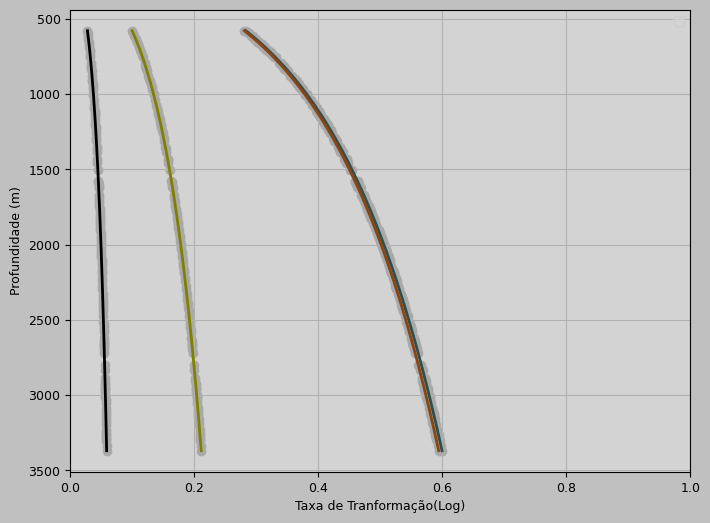

In [18]:
fig = plt.figure()
ax = fig.add_subplot()
y = df["Profundidade"].values
mdn = df["Tr_IH_Log (mdn)"].values
min = df["Tr_IH_Log (min)"].values
med = df["Tr_IH_Log (med)"].values
Ro = df["Tr_Ro_Log"].values
ax.plot(mdn, y, color='darkslategray')
ax.plot(min, y, color='olive')
ax.plot(med, y, color='saddlebrown')
ax.plot(Ro, y, color='black')
ax.scatter(mdn, y, color='darkgray')
ax.scatter(min, y, color='darkgray')
ax.scatter(med, y, color='darkgray')
ax.scatter(Ro, y, color='darkgray')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Taxa de Tranformação(Log)")
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.show()

#### Comparação entre os resultados de Tr (Ro x IH) 

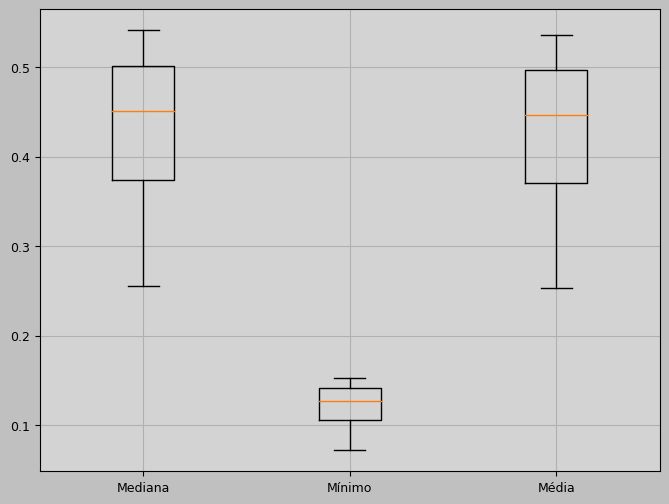

In [19]:
sub1=np.sqrt((df["Tr_IH_Log (mdn)"]-df["Tr_Ro_Log"])**2)
sub2=np.sqrt((df["Tr_IH_Log (min)"]-df["Tr_Ro_Log"])**2)
sub3=np.sqrt((df["Tr_IH_Log (med)"]-df["Tr_Ro_Log"])**2)
data=[sub1,sub2,sub3]
plt.boxplot(data)
custom_labels_x = ['Mediana', 'Mínimo', 'Média']
plt.xticks(np.arange(1, len(custom_labels_x) + 1), custom_labels_x)
plt.style.use(custom_style)
plt.show()


#### Gráfico final (output) para Taxa de Transformação

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


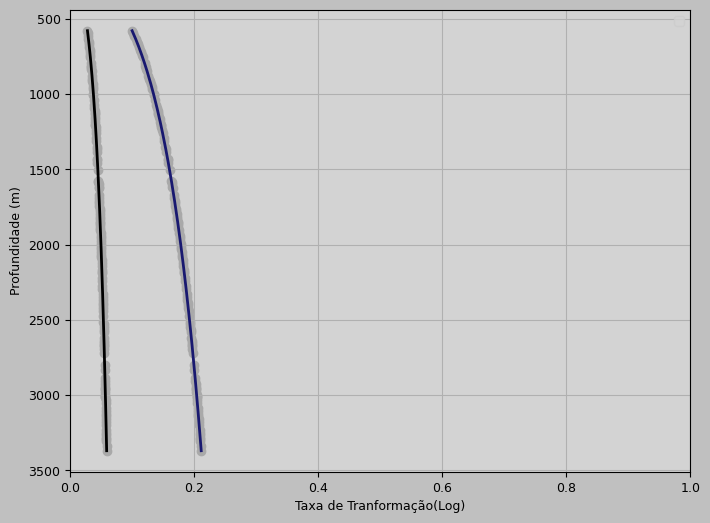

In [20]:
fig = plt.figure()
ax = fig.add_subplot()
#y = df["Profundidade"].values
#mdn = df["Tr_IH_Log (mdn)"].values
#min = df["Tr_IH_Log (min)"].values
#med = df["Tr_IH_Log (med)"].values
#Ro = df["Tr_Ro_Log"].values

if sub1.mean()+sub1.std() < sub2.mean()+sub2.std() and sub1.mean()+sub1.std() < sub3.mean()+sub3.std():
    a=mdn
elif sub2.mean()+sub2.std() < sub1.mean()+sub1.std() and sub2.mean()+sub2.std() < sub3.mean()+sub3.std():
    a=min
else:
    a=med

ax.plot(a, y, color='midnightblue')
ax.plot(Ro, y, color='black')
ax.scatter(a, y, color='darkgray')
ax.scatter(Ro, y, color='darkgray')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Taxa de Tranformação(Log)")
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.show()

#### Diagrama de Van Krevelen

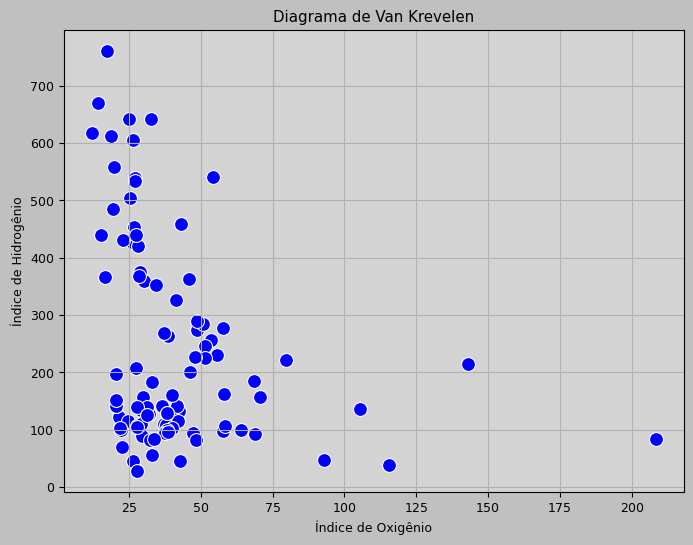

In [21]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x=df["IO"], y=df["IH"], marker='o', color='blue', s=100)
plt.xlabel("Índice de Oxigênio")
plt.ylabel("Índice de Hidrogênio")
plt.title("Diagrama de Van Krevelen")
plt.grid(True)
plt.show()

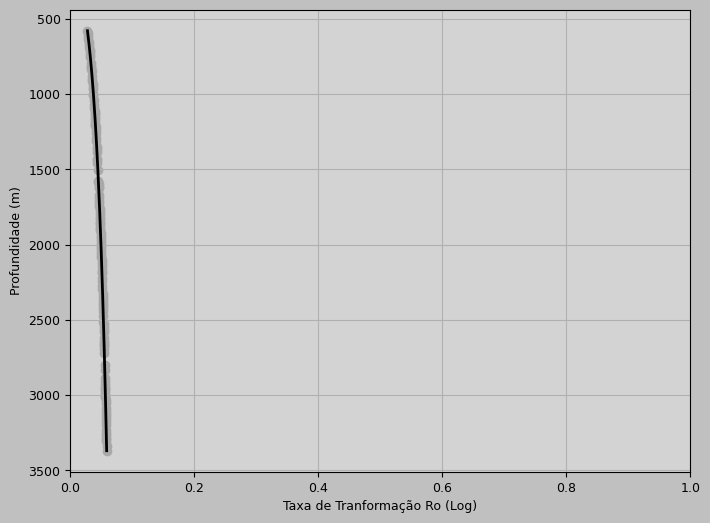

In [22]:
# Taxa de Transformação
plt.scatter(df["Tr_Ro_Log"], df["Profundidade"], color="darkgrey")
plt.plot(df["Tr_Ro_Log"].dropna().values, df["Profundidade"].dropna().values, color="black")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Taxa de Tranformação Ro (Log)")
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.show()

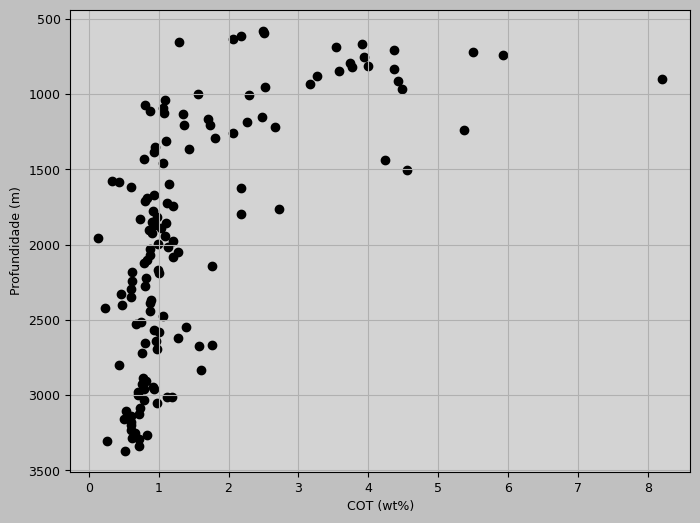

In [23]:
#X=str(input("Parâmetro:"))
col = df["COT"]
plt.scatter(col, df["Profundidade"], color="black")
plt.gca().invert_yaxis()
plt.xlabel("COT (wt%)")
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.show()
